In [40]:
def inv_price_sq(cat):
    """Inverse of price_sq() → retrieves price_per_sqft."""
    return (cat ** 2)


In [41]:
def price_sq(x):
  return x//50

In [42]:
def ConfusionMatrix(y_actual,y_predicted):
  plt.figure(figsize=(10,6))
  y_actu = pd.Series(y_actual, name='Actual')
  y_pred = pd.Series(y_predicted, name='Predicted')
  cm = pd.crosstab(y_actu, y_pred)
  ax = sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return cm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model Accuracy: 57.90%


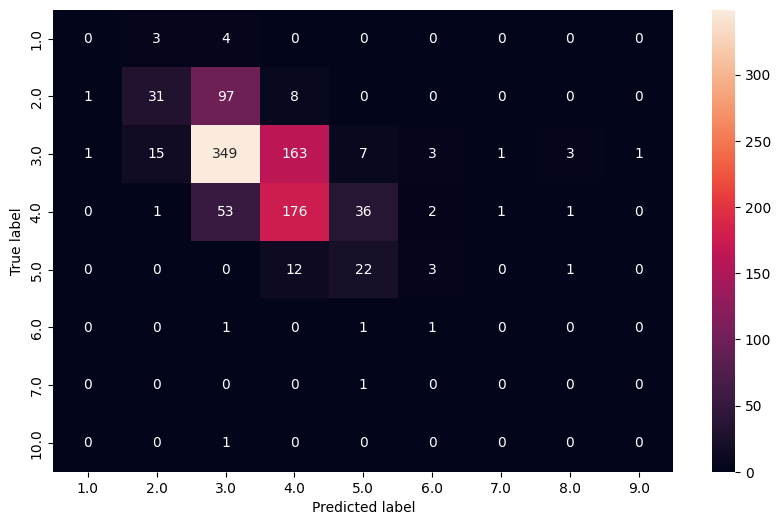

In [43]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')


df = pd.read_csv("/content/drive/MyDrive/ds/cleaned_final.csv")


df = df.drop(columns=["MLS"])

df['kitchen_features'] = df['kitchen_features'].fillna("Unknown")
df['floor_covering'] = df['floor_covering'].fillna("Unknown")

df['fireplaces'] = df['fireplaces'].apply(lambda x: 0 if str(x).lower() in ["none", "0"] else 1)

target = "cat"


numeric_features = ["bathrooms", "garage","sqrt_ft","taxes","lot_acres"]

df['price/sqrft'] = round(df['sold_price']/df['sqrt_ft'], 2)

def encode_era(year):
    if year < 1920:  return 0
    if year < 1950:  return 1
    if year < 1970:  return 2
    if year < 1990:  return 3
    if year < 2005:  return 4
    return 5
df["era"] = df["year_built"].apply(encode_era)


zip_counts = df["zipcode"].value_counts()

df["zip_freq"] = df["zipcode"].map(zip_counts)
# print(df['zip_freq'])
categorical_features=['era', 'zip_freq']
all=numeric_features+categorical_features
X = df[all]
y = df[target] = price_sq(df['price/sqrft'])

X_train, X_test = X.iloc[:4000], X.iloc[4000:]
y_train, y_test = y.iloc[:4000], y.iloc[4000:]

numeric_to_scale = numeric_features

X_train_h = X_train.copy()
X_test_h  = X_test.copy()

# ----- Log-transform skewed numeric features -----
skew_vals = X_train_h[numeric_to_scale].skew()
log_cols = [c for c in numeric_to_scale if abs(skew_vals[c]) > 1 and (X_train_h[c] >= 0).all()]
for c in log_cols:
    X_train_h[c] = np.log1p(X_train_h[c])
    X_test_h[c]  = np.log1p(X_test_h[c])

# ----- Robust scaling for numeric columns with outliers -----
iqr_vals = X_train_h[numeric_to_scale].quantile(0.75) - X_train_h[numeric_to_scale].quantile(0.25)
iqr_threshold = iqr_vals.median() * 2
robust_cols = [c for c in numeric_to_scale if iqr_vals[c] > iqr_threshold]
median_vals = X_train_h[robust_cols].median()
iqr_vals_robust = (X_train_h[robust_cols].quantile(0.75) - X_train_h[robust_cols].quantile(0.25)).replace(0,1)
for c in robust_cols:
    X_train_h[c] = (X_train_h[c] - median_vals[c]) / iqr_vals_robust[c]
    X_test_h[c]  = (X_test_h[c]  - median_vals[c]) / iqr_vals_robust[c]

# ----- Standard scale remaining numeric columns -----
standard_cols = [c for c in numeric_to_scale if c not in robust_cols]
mean_vals = X_train_h[standard_cols].mean()
std_vals  = X_train_h[standard_cols].std().replace(0,1)
for c in standard_cols:
    X_train_h[c] = (X_train_h[c] - mean_vals[c]) / std_vals[c]
    X_test_h[c]  = (X_test_h[c]  - mean_vals[c]) / std_vals[c]


X_train = X_train_h.values
X_test  = X_test_h.values
y_train = y_train.values
y_test  = y_test.values


class KNNClassifier:
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, K=5):
        y_pred = []
        for x in X:
            # Euclidean distances
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            # Indices of K nearest neighbors
            idx = np.argsort(distances)[:K]
            # Majority vote
            labels, counts = np.unique(self.y_train[idx], return_counts=True)
            y_pred.append(labels[np.argmax(counts)])
        return np.array(y_pred)

# Accuracy function
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


knn_instance = KNNClassifier()
knn_instance.fit(X_train, y_train)

y_pred = knn_instance.predict(X_test, K=2)
print("Model Accuracy: {:.2f}%".format(accuracy(y_test, y_pred) * 100))

cm = ConfusionMatrix(y_test, y_pred)
plt.show()




In [44]:

def predict_cat(bathrooms, garage, sqrt_ft, taxes, lot_acres, year_built, zipcode):
    """
    Predicts category and estimated sold price using:
       - Hybrid scaler fitted above
       - KNN classifier
       - price_sq() inverse transform
    """


    def encode_era(year):
        if year < 1920:  return 0
        if year < 1950:  return 1
        if year < 1970:  return 2
        if year < 1990:  return 3
        if year < 2005:  return 4
        return 5
    era = encode_era(year_built)


    zip_freq = zip_counts.get(zipcode, 0)  # Use 0 if zipcode not in training set


    new = pd.DataFrame([[bathrooms, garage, sqrt_ft, taxes, lot_acres, era, zip_freq]],
                       columns=numeric_features + categorical_features)


    new_scaled = new.copy()

    for c in log_cols:
        new_scaled[c] = np.log1p(new_scaled[c])

    for c in robust_cols:
        new_scaled[c] = (new_scaled[c] - median_vals[c]) / iqr_vals_robust[c]

    for c in standard_cols:
        new_scaled[c] = (new_scaled[c] - mean_vals[c]) / std_vals[c]



    new_np = new_scaled.values
    pred_cat = knn_instance.predict(new_np, K=5)[0]


    price_per_sqft = inv_price_sq(pred_cat)  # your inverse function
    predicted_price = price_per_sqft * sqrt_ft

    return {
        "predicted_category": pred_cat,
        "price_per_sqft": price_per_sqft,
        "estimated_sold_price": predicted_price
    }


In [45]:
bathrooms, garage, sqrt_ft, taxes, lot_acres, year_built, zipcode=3,2,2487,2450,1,1973,85718

answer=predict_cat(bathrooms, garage, sqrt_ft, taxes, lot_acres, year_built, zipcode)

In [46]:
answer

{'predicted_category': np.float64(5.0),
 'price_per_sqft': np.float64(25.0),
 'estimated_sold_price': np.float64(62175.0)}

In [47]:
sold_price=330000


In [48]:
true_cat=price_sq(261)
true_cat

5

In [49]:
answer

{'predicted_category': np.float64(5.0),
 'price_per_sqft': np.float64(25.0),
 'estimated_sold_price': np.float64(62175.0)}

In [50]:
def accuracy(y,y_hat):
  return np.mean(y==y_hat)

In [51]:
def cat_accuracy(pred_cat, true_cat):
    """
    Computes how close the predicted cat is to the actual cat.
    Returns percent accuracy (higher is better).
    """
    diff = abs(pred_cat - true_cat)
    perc_error = diff / true_cat * 100
    perc_accuracy = 100 - perc_error
    return perc_accuracy



In [52]:

pa = cat_accuracy(answer['predicted_category'],true_cat)

print("cat Accuracy: {:.2f}%".format(pa))


cat Accuracy: 100.00%
